In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2023-06-22 20:20:37.205349: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 20:20:37.237859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 20:20:37.238458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 20:20:38.059614: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Unexpected observations
80eb68a106a11c44a63fcdc7da8a6498

1. Load model
2. Select output layers
3. Parse image
4. Draw activation maps

In [2]:
BASE_DIR = "../../../mammography/dataset/roi_preprocessed"

In [3]:
pathology_model = tf.keras.models.load_model("../../application/public/models/pathology-classification-ensemble")

In [4]:
df = pd.read_csv("../../../mammography/roi_preprocessed_metadata.csv").query("dataset == 'test'")
df.head()

Unnamed: 0                 original_checksum   
1317        1317  01d92e6afdb23d4cb8c47957d1752468  \
1318        1318  7744b0030f652f04b7881e13b899ac8e   
1319        1319  e898aec727010780134e02a912f8ec0e   
1320        1320  470b88f56461fe466cb064e56623c006   
1321        1321  fc193735b1692e18ccf8d3e193fa545f   

                                 cropped_img   
1317  01d92e6afdb23d4cb8c47957d1752468_0.png  \
1318  7744b0030f652f04b7881e13b899ac8e_0.png   
1319  e898aec727010780134e02a912f8ec0e_0.png   
1320  470b88f56461fe466cb064e56623c006_0.png   
1321  fc193735b1692e18ccf8d3e193fa545f_0.png   

                                 cropped_mask_img    x     y  width  height   
1317  01d92e6afdb23d4cb8c47957d1752468_mask_0.png  160  2188    551     551  \
1318  7744b0030f652f04b7881e13b899ac8e_mask_0.png   99  3110    525     525   
1319  e898aec727010780134e02a912f8ec0e_mask_0.png  251  3177    276     276   
1320  470b88f56461fe466cb064e56623c006_mask_0.png  207  3220    295     295   
1321  fc193735b1692e18ccf8d3e193fa545f_mask_0.png  437  1275    583     583   

          shape         margin  type      label  assessment  subtlety   
1317  IRREGULAR     SPICULATED  mass  MALIGNANT           5         5  \
1318  IRREGULAR     SPICULATED  mass  MALIGNANT           5         5   
1319      ROUND  CIRCUMSCRIBED  mass  MALIGNANT           4         4   
1320      ROUND    ILL_DEFINED  mass  MALIGNANT           4         4   
1321      ROUND       OBSCURED  mass     BENIGN           0         2   

      unaligned dataset  
1317      False    test  
1318      False    test  
1319      False    test  
1320      False    test  
1321      False    test

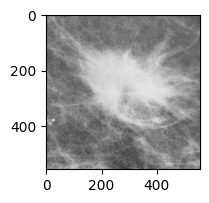

Unnamed: 0                 original_checksum   
1518        1518  7da3b7e9f0eb73b51f6979389ac627f0  \

                                 cropped_img   
1518  7da3b7e9f0eb73b51f6979389ac627f0_0.png  \

                                 cropped_mask_img    x    y  width  height   
1518  7da3b7e9f0eb73b51f6979389ac627f0_mask_0.png  988  921    556     556  \

     shape      margin  type      label  assessment  subtlety  unaligned   
1518  OVAL  SPICULATED  mass  MALIGNANT           5         5      False  \

     dataset  
1518    test

In [5]:
sample = df.sample()
plt.figure(figsize=(2, 2))
plt.imshow(plt.imread(f"{BASE_DIR}/{sample.cropped_img.values[0]}"))
plt.show()
sample

In [6]:
for layer in pathology_model.layers[3].layers:
    print(layer.name)

input_4
conv1_pad
conv1_conv
pool1_pad
pool1_pool
conv2_block1_preact_bn
conv2_block1_preact_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_pad
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_out
conv2_block2_preact_bn
conv2_block2_preact_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_pad
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_out
conv2_block3_preact_bn
conv2_block3_preact_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_pad
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
max_pooling2d_9
conv2_block3_3_conv
conv2_block3_out
conv3_block1_preact_bn
conv3_block1_preact_relu
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_pad
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_out
conv3_block2_p

In [7]:
outputs = [pathology_model.layers[3].get_layer(layer_name).output for layer_name in ["conv1_conv", "conv2_block2_out", "conv3_block3_out", "conv4_block5_out", "conv5_block3_out"]]
outputs

[<KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'conv1_conv')>,
 <KerasTensor: shape=(None, 56, 56, 256) dtype=float32 (created by layer 'conv2_block2_out')>,
 <KerasTensor: shape=(None, 28, 28, 512) dtype=float32 (created by layer 'conv3_block3_out')>,
 <KerasTensor: shape=(None, 14, 14, 1024) dtype=float32 (created by layer 'conv4_block5_out')>,
 <KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>]

In [8]:
def visualize_activations(inputs, input, output):
    model = tf.keras.Model(inputs=input, outputs=output)

    predictions = model.predict(inputs)

    filters = tf.squeeze(predictions)

    rows = 3
    cols = 20

    plt.figure(figsize=(cols, rows))
    print(filters.shape)

    for filter in range(1, rows * cols + 1):
        plt.subplot(rows, cols, filter)
        plt.axis("off")
        plt.imshow(filters[:, :, filter], cmap="inferno")

In [9]:
input = pathology_model.layers[3].input

In [10]:
image = tf.keras.utils.load_img(f"{BASE_DIR}/{sample.cropped_img.values[0]}").resize(size=(224, 224))
image_expand = tf.expand_dims(image, axis=0)
mask = tf.keras.utils.load_img(f"{BASE_DIR}/{sample.cropped_mask_img.values[0]}").resize(size=(224, 224))
shape = tf.bitwise.bitwise_and(image, mask)
shape_expand = tf.expand_dims(shape, axis=0)
margin = tf.bitwise.bitwise_and(image, tf.bitwise.invert(mask))
margin_expand = tf.expand_dims(margin, axis=0)

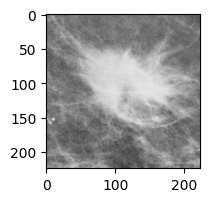

1/1 [==============================] - 0s 57ms/step
(112, 112, 64)


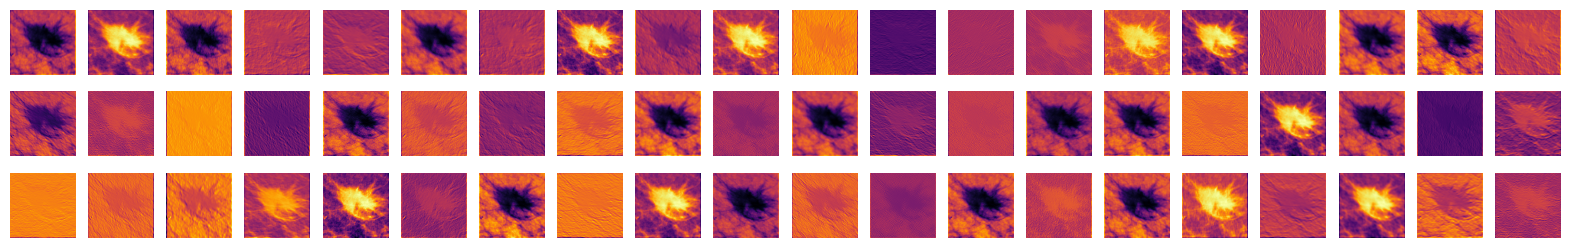

1/1 [==============================] - 0s 86ms/step
(56, 56, 256)


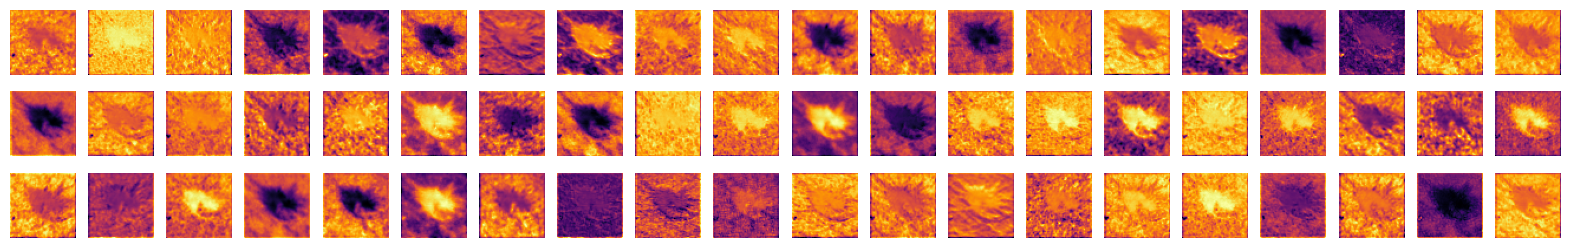

1/1 [==============================] - 0s 159ms/step
(28, 28, 512)


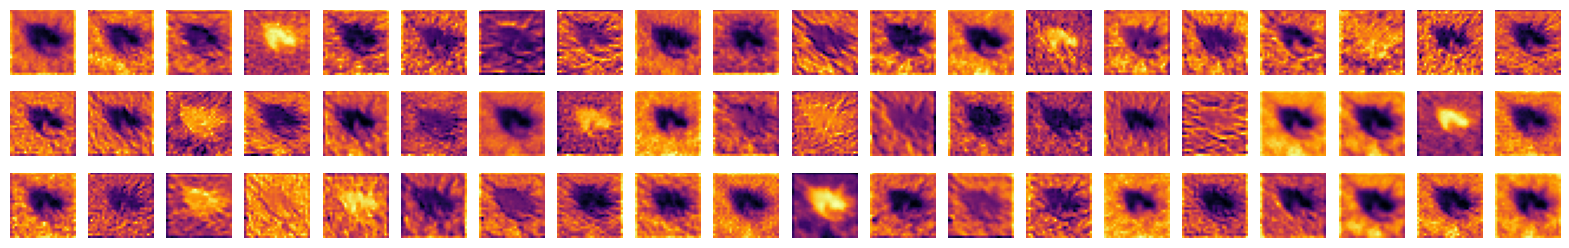

1/1 [==============================] - 0s 282ms/step
(14, 14, 1024)


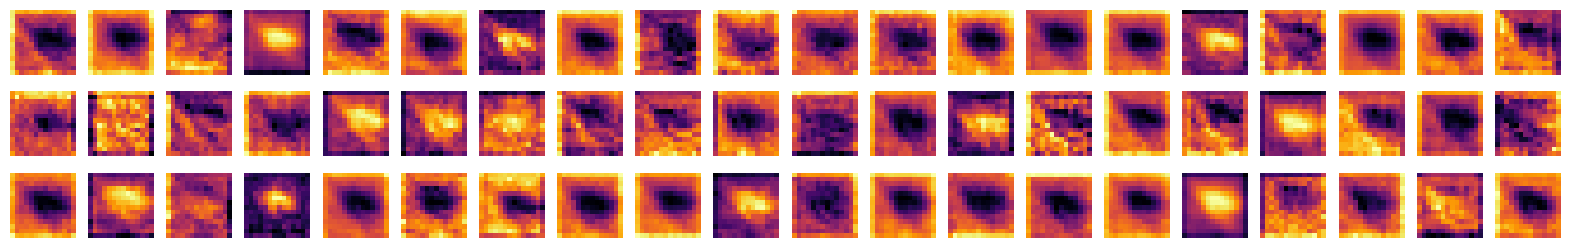

1/1 [==============================] - 0s 360ms/step
(7, 7, 2048)


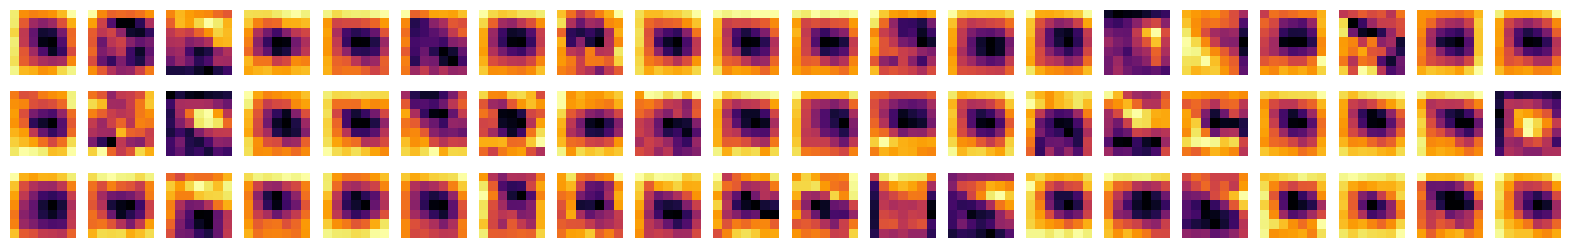

In [11]:
plt.figure(figsize=(2, 2))
plt.imshow(image)
plt.show()

for output in outputs:
    visualize_activations(image_expand, input, output)
    plt.show()

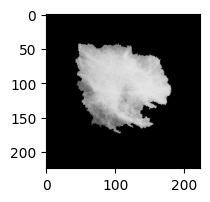

1/1 [==============================] - 0s 28ms/step
(112, 112, 64)


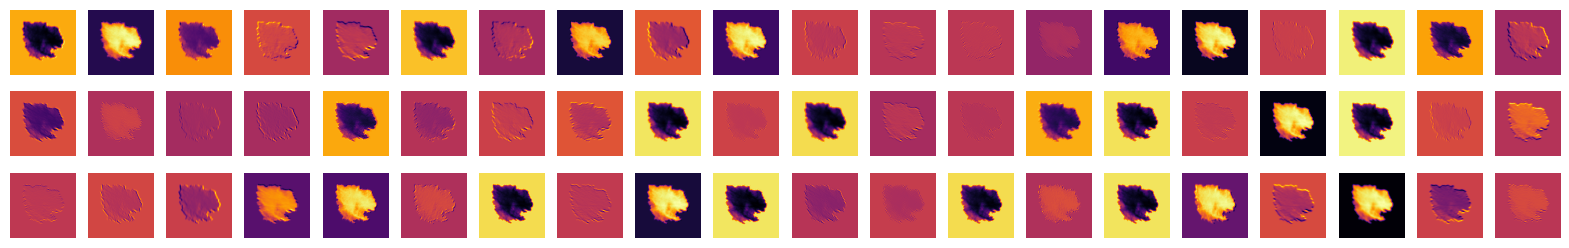

1/1 [==============================] - 0s 74ms/step
(56, 56, 256)


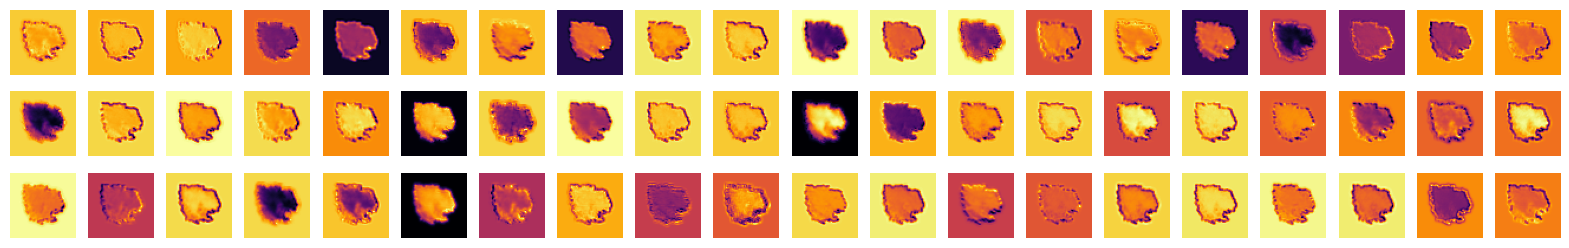

1/1 [==============================] - 0s 158ms/step
(28, 28, 512)


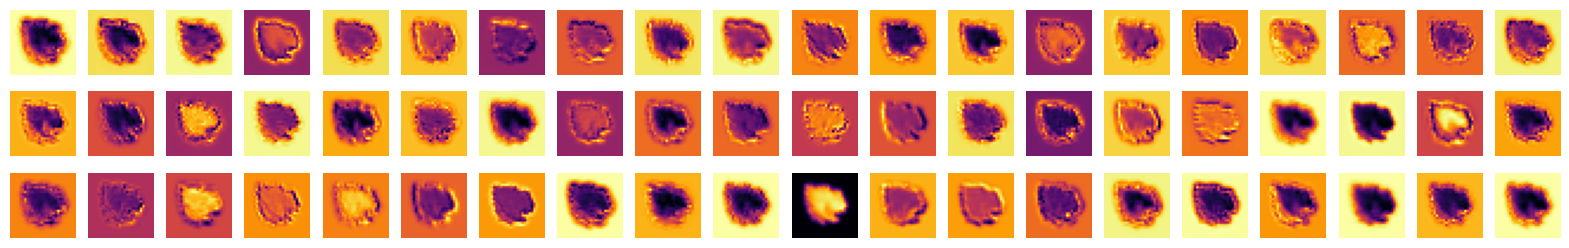

1/1 [==============================] - 0s 276ms/step
(14, 14, 1024)


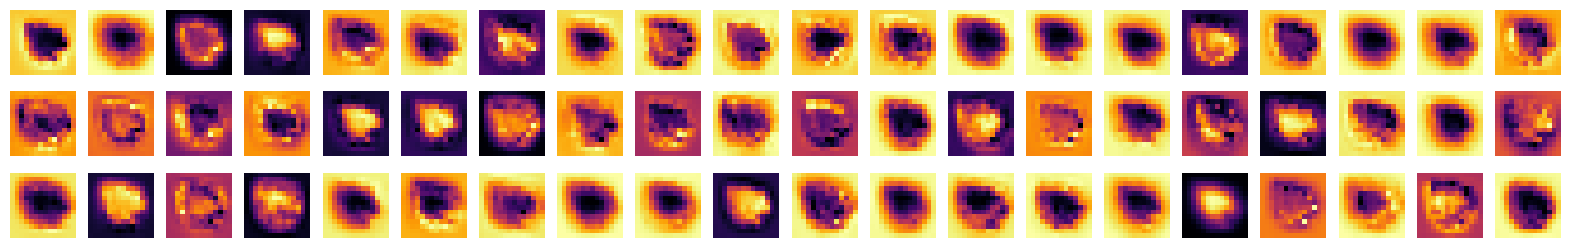

1/1 [==============================] - 0s 365ms/step
(7, 7, 2048)


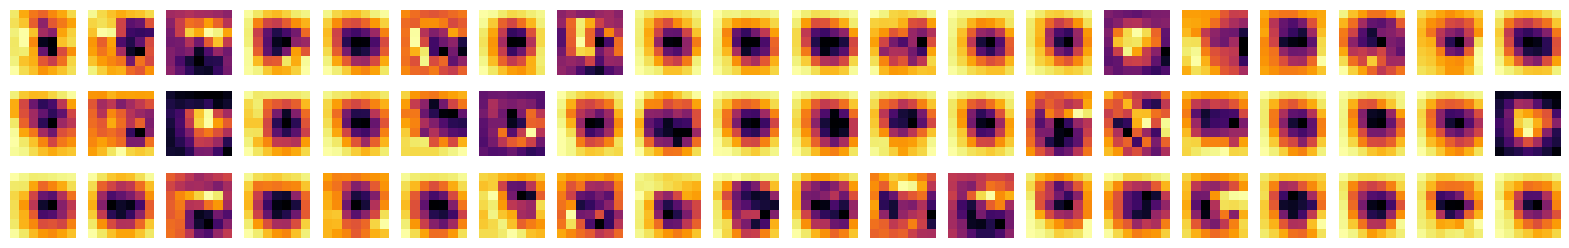

In [12]:
plt.figure(figsize=(2, 2))
plt.imshow(shape)
plt.show()

for output in outputs:
    visualize_activations(shape_expand, input, output)
    plt.show()

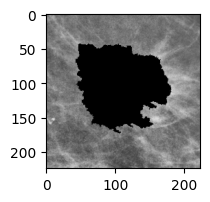

1/1 [==============================] - 0s 26ms/step
(112, 112, 64)


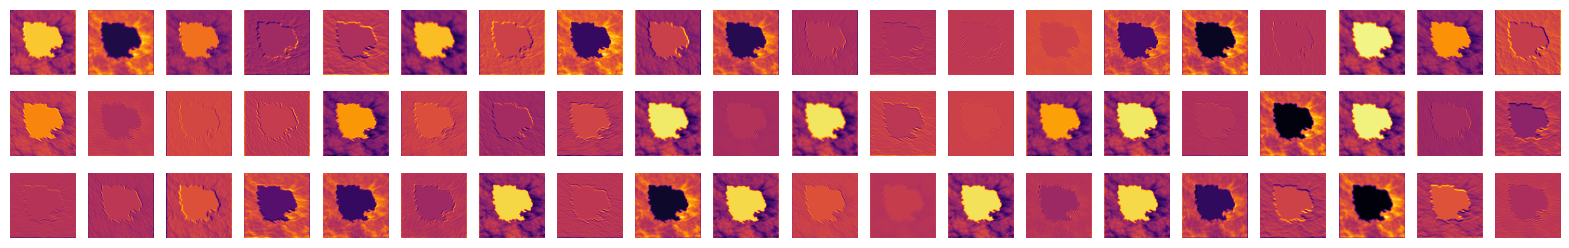

1/1 [==============================] - 0s 76ms/step
(56, 56, 256)


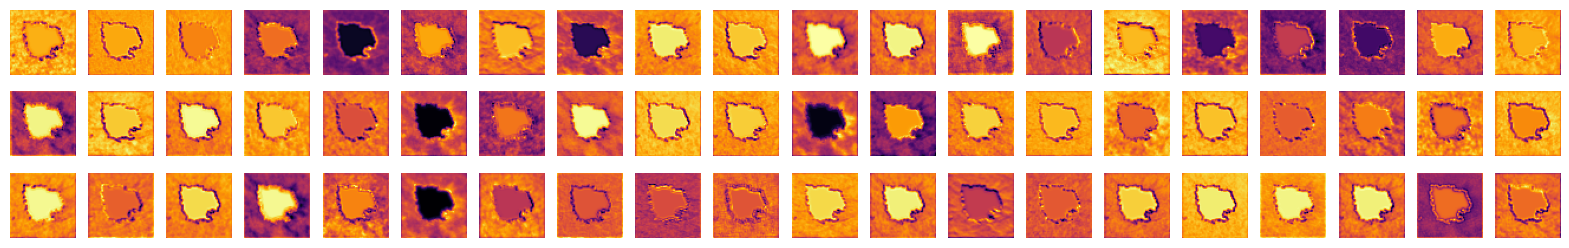

1/1 [==============================] - 0s 159ms/step
(28, 28, 512)


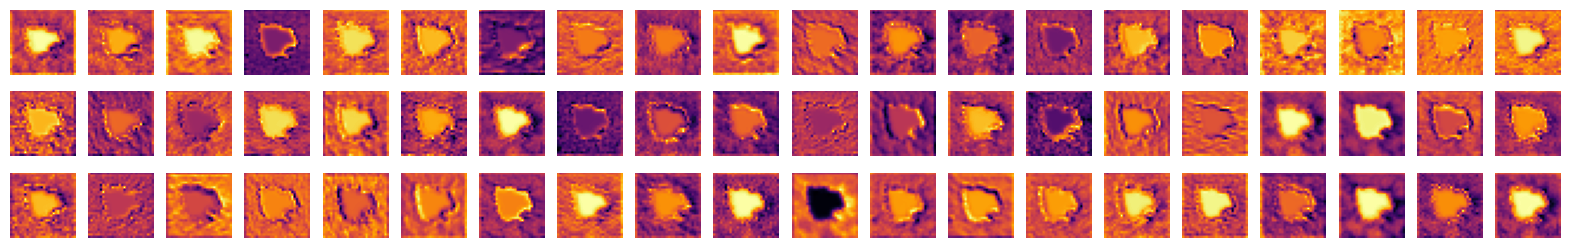

1/1 [==============================] - 0s 275ms/step
(14, 14, 1024)


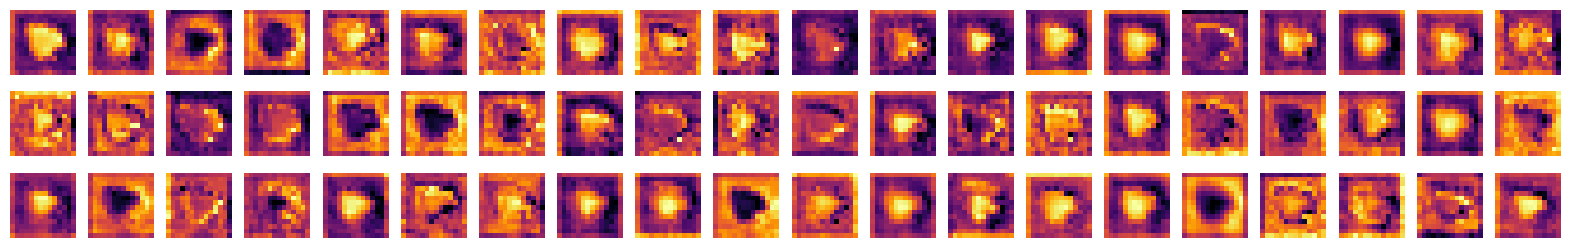

1/1 [==============================] - 0s 363ms/step
(7, 7, 2048)


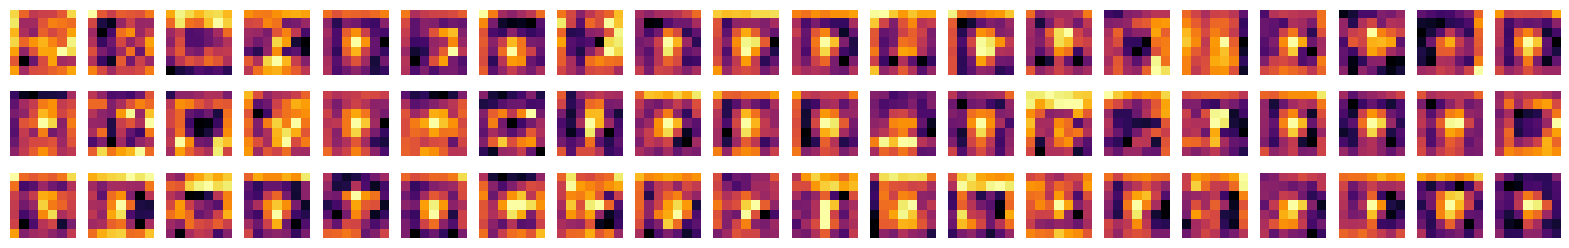

In [13]:
plt.figure(figsize=(2, 2))
plt.imshow(margin)
plt.show()

for output in outputs:
    visualize_activations(margin_expand, input, output)
    plt.show()

## Trans unet

In [14]:
from tensorflow.keras import backend as K

def _iou_coef(y_true, y_pred, smooth=0):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def _iou_loss(y_true, y_pred):
    return 1 - _iou_coef(y_true, y_pred)

In [15]:
trans_unet = tf.keras.models.load_model("../models/trans-unet/exported_model", custom_objects={"iou_loss": _iou_loss, "iou_coef": _iou_coef})

2023-06-22 20:21:16.419687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'images' with dtype float and shape [?,256,256,3]
	 [[{{node images}}]]
2023-06-22 20:21:16.422200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype float and shape [?,256,256,3]
	 [[{{node Placeholder}}]]
2023-06-22 20:21:16.425634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'patch' with dtype float and shape [?,?,192]
	 [[{{node patc

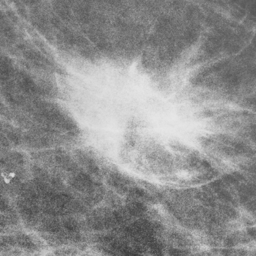

In [16]:
image = tf.keras.utils.load_img(f"{BASE_DIR}/{sample.cropped_img.values[0]}").resize(size=(256, 256))
image_expand = tf.expand_dims(image, axis=0)
image

1/1 [==============================] - 0s 77ms/step


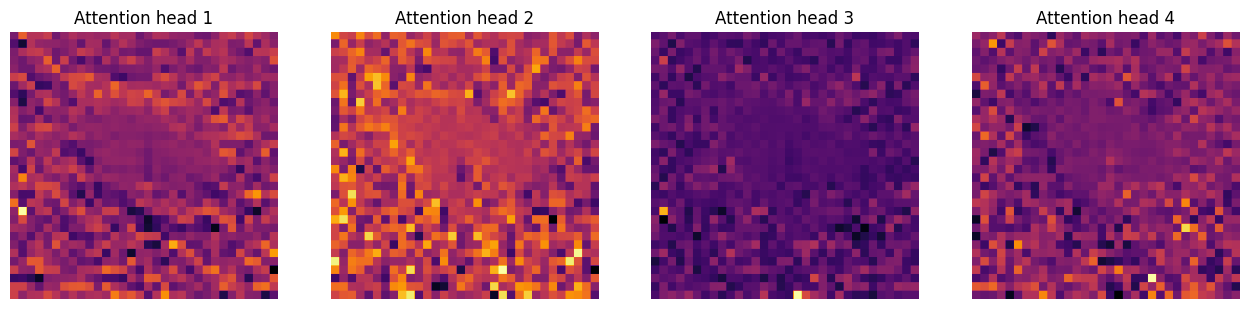

1/1 [==============================] - 0s 141ms/step


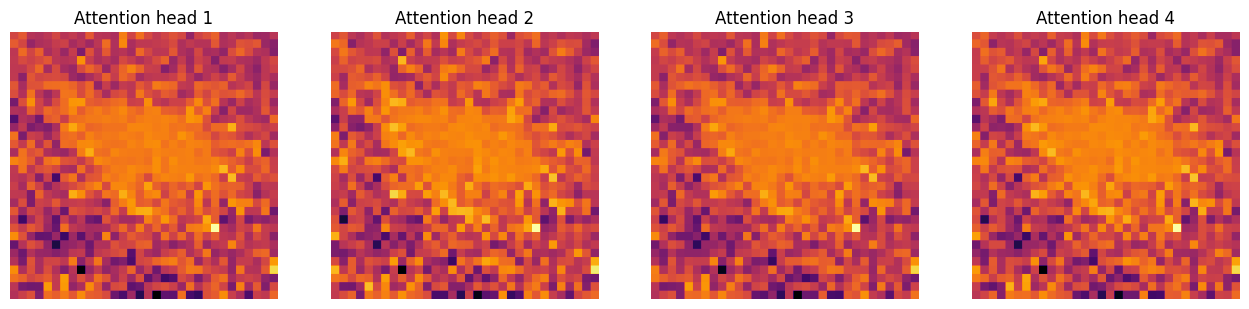

1/1 [==============================] - 0s 212ms/step


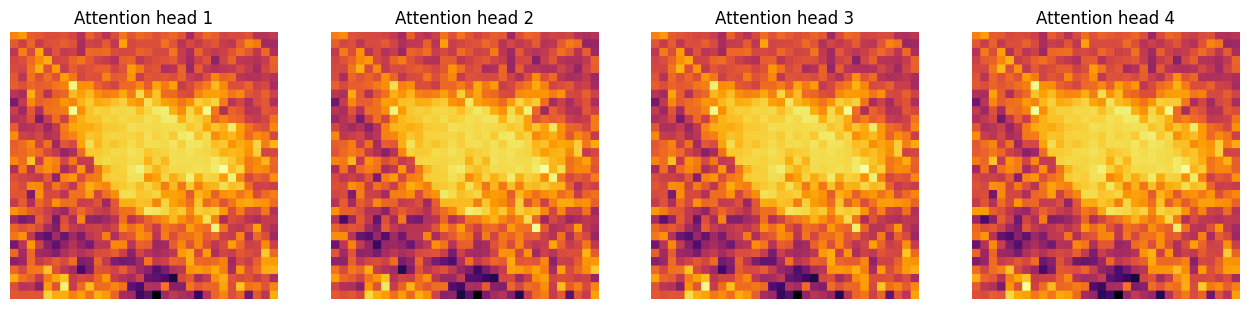

1/1 [==============================] - 0s 281ms/step


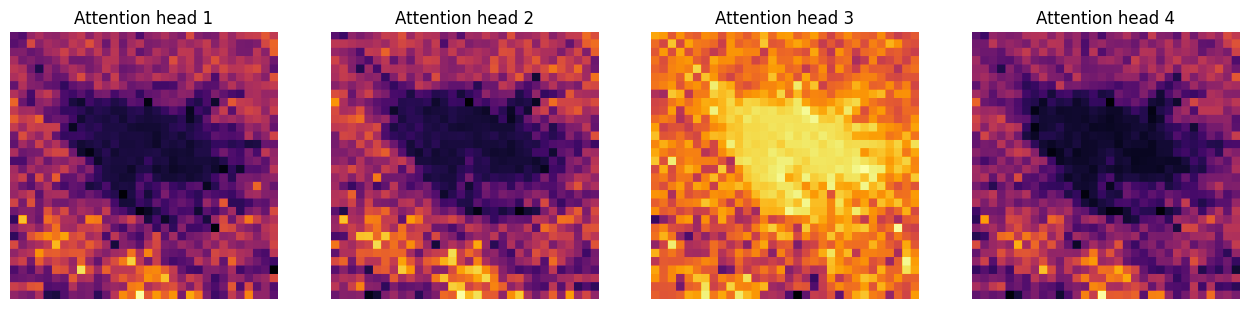

1/1 [==============================] - 0s 345ms/step


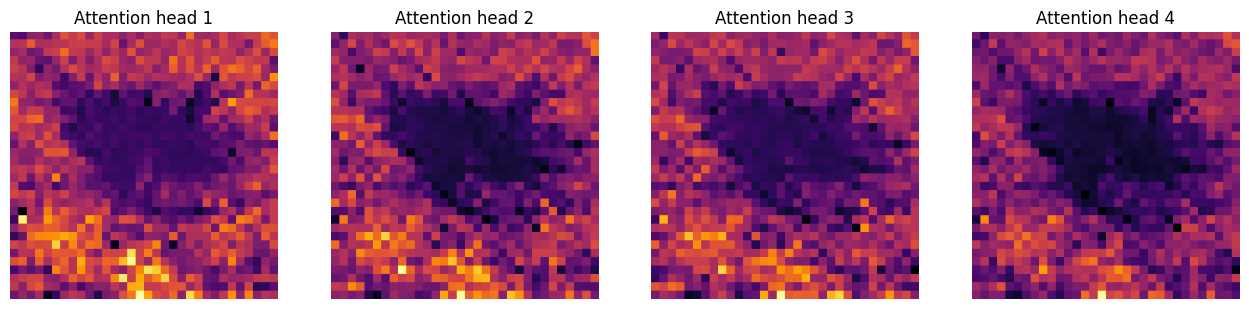

1/1 [==============================] - 0s 411ms/step


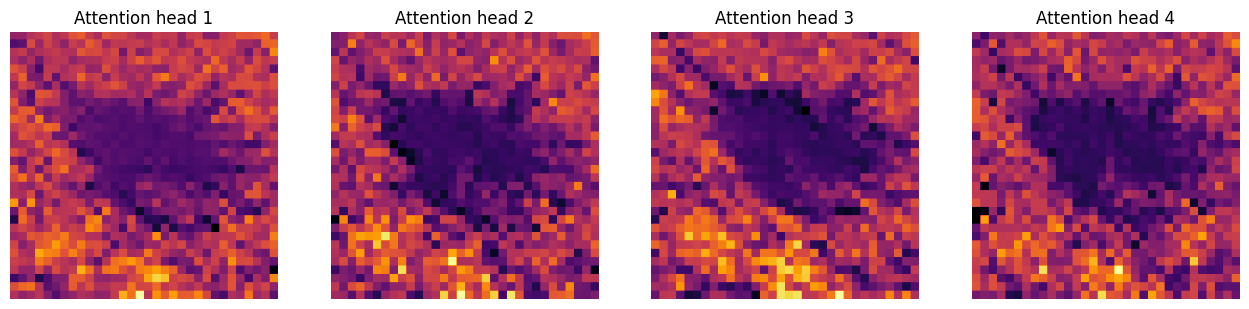

1/1 [==============================] - 0s 490ms/step


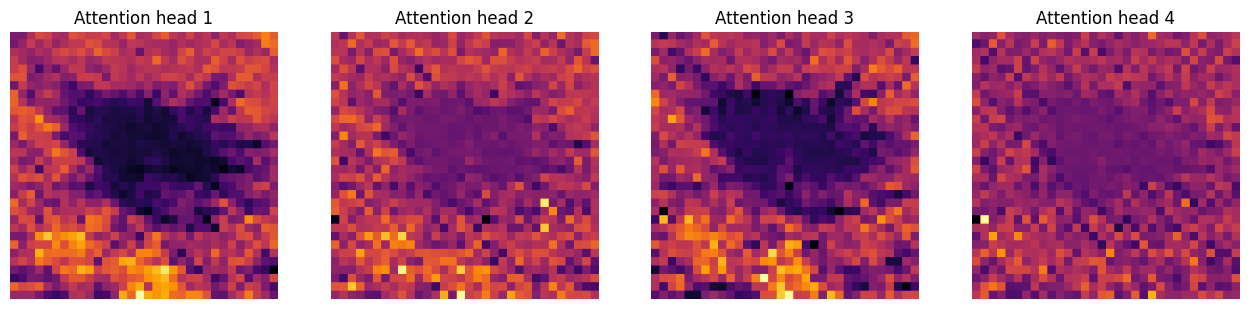

1/1 [==============================] - 1s 624ms/step


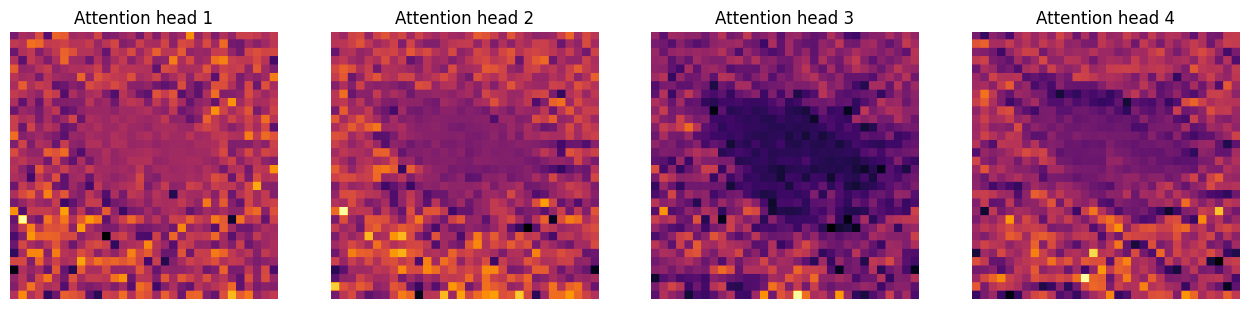

In [17]:
for x in range(0, 8):
    input = trans_unet.input
    if x == 0:
        num_head = ""
    else:
        num_head = f"_{x}"
    output = trans_unet.get_layer(f"multi_head_attention{num_head}").output[1]
    trans_unet_attention_model = tf.keras.Model(inputs=input, outputs=output[0])

    attention_scores = trans_unet_attention_model.predict(image_expand)

    num_heads = 4
    plt.figure(figsize=(20, 4))
    mean_attention_scores = tf.reduce_mean(attention_scores, axis=1)

    for i in range(num_heads):
        plt.subplot(1, num_heads + 1, i + 1)
        attention_map = tf.image.resize(tf.reshape(mean_attention_scores[i], shape=(32, 32, 1)), size=(256, 256), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        # plt.imshow(image)
        plt.imshow(attention_map, alpha=1, cmap="inferno")
        plt.title(f"Attention head {i + 1}")
        plt.axis("off")
    plt.show()

## Visualize encoder maps

In [18]:
input = trans_unet.input
trans_unet_attention_model = tf.keras.Model(inputs=input, outputs=output)

1/1 [==============================] - 0s 81ms/step
(128, 128, 64)


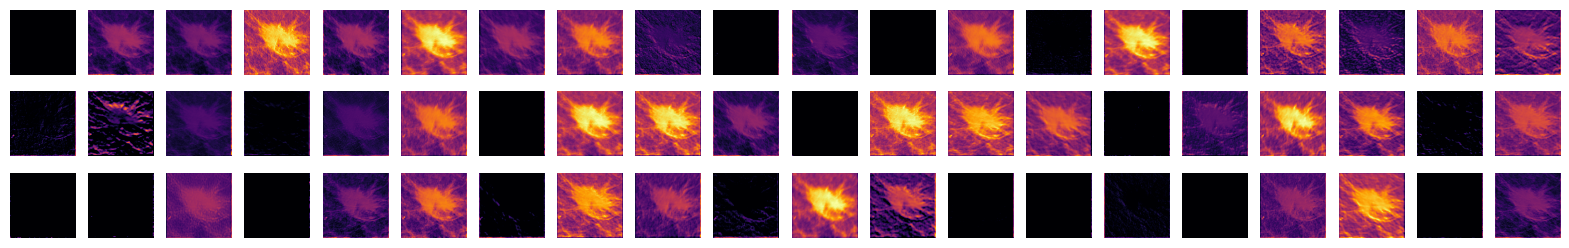

1/1 [==============================] - 0s 116ms/step
(64, 64, 128)


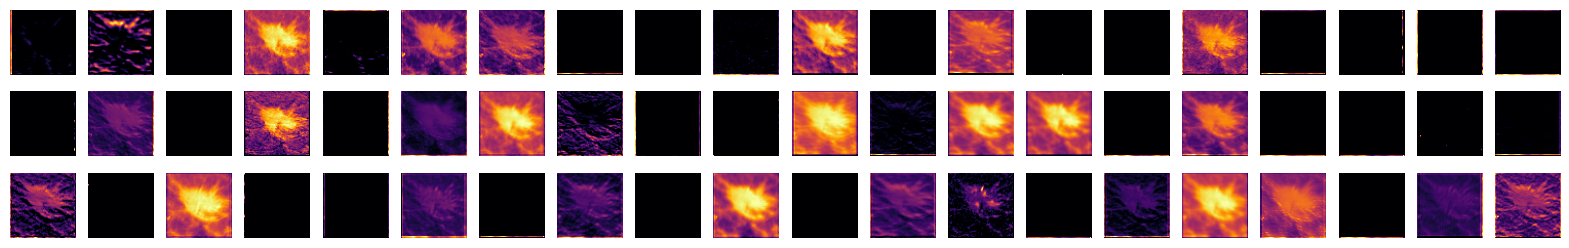

1/1 [==============================] - 0s 136ms/step
(32, 32, 256)


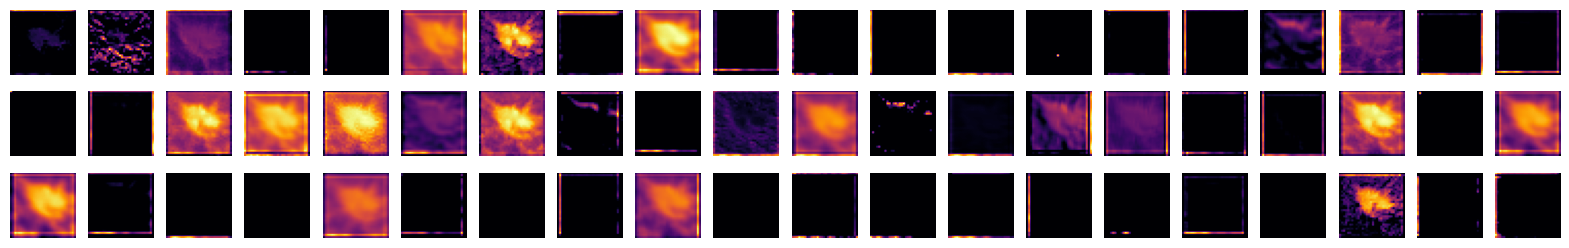

1/1 [==============================] - 0s 156ms/step
(16, 16, 512)


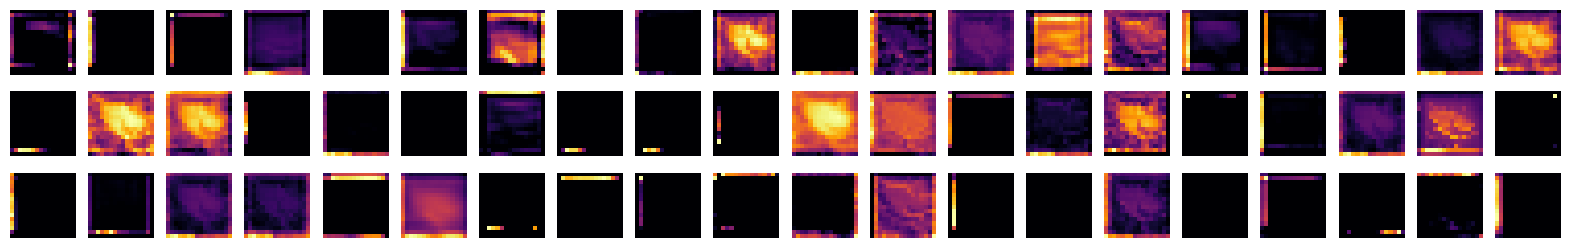

In [19]:
for i in range(1, 5):
    num_layer = f"_{i}"
    output = trans_unet.get_layer(f"re_lu{num_layer}").output
    visualize_activations(image_expand, input, output)
    plt.show()